# **Importing libraries**

In [ ]:
import os
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.resnet50 import ResNet50
import matplotlib.pyplot as plt
import torch
from scipy.special import erfinv
import multiprocessing
import tarfile
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Loading Dataset**

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()
# Normalize the input image so that each pixel value is between 0 to 1.
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

169001437/169001437 [==============================] - 6s 0us/step


In [ ]:
IMG_SIZE = 224
num_classes = 100

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

# **Building model**

In [ ]:
def build_model(x_train):
    input_layer = tf.keras.layers.Input(shape=(32,32, 3))
    up_sample_layer = tf.keras.layers.UpSampling2D(size=(7,7))(input_layer)
    model = ResNet50(include_top=False, input_tensor=up_sample_layer, weights="imagenet")
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False

    # # Freeze the layers
    # model.trainable = False
    # Rebuild top
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tf.keras.layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x, training = True)
    x = tf.keras.layers.Dense(300, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x, training = True)

    outputs = tf.keras.layers.Dense(num_classes, activation = "sigmoid", name="pred")(x)
    model = tf.keras.Model(input_layer, outputs)
    model.compile(optimizer='adam',
                loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])

    return model

In [ ]:
model = build_model(x_train)

94765736/94765736 [==============================] - 2s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 up_sampling2d (UpSampling2  (None, 224, 224, 3)          0         ['input_1[0][0]']             
 D)                                                                                               
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['up_sampling2d[0][0]']       
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']       

# **Training the model**

In [ ]:
model.fit(x_train,y_train, epochs=10)

Epoch 1/10
1563/1563 [==============================] - 426s 253ms/step - loss: 0.0408 - accuracy: 0.3932
Epoch 2/10
1563/1563 [==============================] - 396s 253ms/step - loss: 0.0228 - accuracy: 0.6074
Epoch 3/10
1563/1563 [==============================] - 395s 253ms/step - loss: 0.0197 - accuracy: 0.6613
Epoch 4/10
1563/1563 [==============================] - 395s 253ms/step - loss: 0.0180 - accuracy: 0.6954
Epoch 5/10
1563/1563 [==============================] - 396s 254ms/step - loss: 0.0170 - accuracy: 0.7158
Epoch 6/10
1563/1563 [==============================] - 396s 253ms/step - loss: 0.0160 - accuracy: 0.7330
Epoch 7/10
1563/1563 [==============================] - 396s 254ms/step - loss: 0.0153 - accuracy: 0.7446
Epoch 8/10
1563/1563 [==============================] - 396s 253ms/step - loss: 0.0147 - accuracy: 0.7564
Epoch 9/10
1563/1563 [==============================] - 396s 254ms/step - loss: 0.0141 - accuracy: 0.7666
Epoch 10/10
1563/1563 [=======================

# **Save trained model**

In [ ]:
model.save('drive/MyDrive/DL_Project/CFAR100/cfar100_model.keras')

# **Loading Saved Model**

In [ ]:
saved_model = tf.keras.models.load_model('drive/MyDrive/DL_Project/CFAR100/cfar100_model.keras')

# **TF-LITE Models - normal and quantized**

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(saved_model)

tflite_model = converter.convert()

In [ ]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(saved_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()

# **Storing the TF-LITE models - with and without quantization**

In [ ]:
import pathlib

tflite_models_dir = pathlib.Path("/tmp/mnist_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the unquantized/float model:
tflite_model_file = tflite_models_dir/"mnist_model.tflite"
tflite_model_file.write_bytes(tflite_model)
# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"mnist_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

In [ ]:
tflite_models_dir = 'drive/MyDrive/DL_Project/CFAR100/'

# Save the unquantized/float model:
tflite_model_file = tflite_models_dir + "cfar100_model.tflite"
with open(tflite_model_file, 'wb') as f:
    f.write(tflite_model)
# Save the quantized/:
tflite_quantized_model_file = tflite_models_dir + "cfar100_model_quantized_int8.tflite"
with open(tflite_quantized_model_file, 'wb') as f:
    f.write(tflite_model_quant)

In [ ]:
#load model
tflite_models_dir = 'drive/MyDrive/DL_Project/CFAR100/'
model_file_name = 'cfar100_model_quantized_int8.tflite'

interpreter = tf.lite.Interpreter(model_path=tflite_models_dir+model_file_name)

# **Find sigmoid quantization parameters**

In [ ]:
interpreter.allocate_tensors()

# Get information about the input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Assuming the sigmoid layer is the first and only output layer
sigmoid_layer_index = 0

# Get quantization parameters for the sigmoid layer
print(output_details)
output_scale = output_details[sigmoid_layer_index]['quantization_parameters']['scales'][0]
output_zero_point = output_details[sigmoid_layer_index]['quantization_parameters']['zero_points'][0]

print(f"Output scale: {output_scale}")
print(f"Output zero point: {output_zero_point}")

In [ ]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_image_indices), 100))
  for i, test_image_index in enumerate(test_image_indices):
    test_image = x_test[test_image_index]
    test_label = y_test[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    max_index = np.argmax(output)
    # print(max_index)
    predictions[i][max_index] = 1

  return predictions

In [ ]:
%%timeit
run_tflite_model(tflite_models_dir+model_file_name, [0])

243 ms ± 9.54 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_file, model_type):
  print(len(x_test))
  x_tes = x_test[0:1]
  y_tes = y_test[0:1]
  # print(x_tes)
  test_image_indices = range(x_tes.shape[0])
  print(len(test_image_indices))
  predictions = run_tflite_model(tflite_file, test_image_indices)
  print(predictions)
  accuracy = accuracy_score(predictions, y_tes)*100
  f1_score_val = f1_score(predictions, y_tes, average='micro')

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(x_tes )))
  print('%s model f1 score is %.4f%% (Number of test samples=%d)' % (
      model_type, f1_score_val, len(x_tes )))

In [ ]:
evaluate_model(tflite_models_dir+model_file_name, model_type="Float")

In [ ]:
evaluate_model(tflite_models_dir+model_file_name, model_type="Quantized")

In [ ]:
def run_tflite_model_single_sample_raw(interpreter, input_details, output_details, test_image, test_label):
    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    # print(output)
    return output

def mc_eval_single_sample(test_image_index, tflite_file, no_itr, num_classes, conf_perc_factor, threshold):
    # Initialize the interpreter
    threshold = (threshold/output_scale) + output_zero_point
    interpreter = tf.lite.Interpreter(model_path=str(tflite_file), num_threads=multiprocessing.cpu_count())
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    test_image = x_test[test_image_index]
    test_label = y_test[test_image_index]

    conf_level_factor = np.sqrt(2) * erfinv(conf_perc_factor)
    predictions = np.zeros((no_itr, num_classes))

    for i in range(no_itr):
        predictions[i] = run_tflite_model_single_sample_raw(interpreter, input_details, output_details, test_image, test_label)

    avg_preds = predictions.mean(axis = 0)
    sd_preds = predictions.std(axis = 0)
    final_pred = np.zeros(num_classes)

    for i in range(num_classes):
        conf_int_low = avg_preds[i] - conf_level_factor*sd_preds[i]
        conf_int_up = avg_preds[i] + conf_level_factor*sd_preds[i]

        if conf_int_low > threshold:
            final_pred[i] = 1
        elif conf_int_up < threshold:
            final_pred[i] = 0
        else:
            final_pred[i] = -1

    return final_pred

def run_mc_eval_on_dataset(tflite_file, no_itr, num_classes, conf_perc_factor, threshold):
    threshold = (threshold/output_scale) + output_zero_point
    conf_level_factor = np.sqrt(2) * erfinv(conf_perc_factor)
    # Initialize the interpreter
    interpreter = tf.lite.Interpreter(model_path=str(tflite_file), num_threads=multiprocessing.cpu_count())
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]
    test_image_indices = range(x_test.shape[0])
    test_image_indices = range(100)
    final_predictions = np.zeros((len(test_image_indices), num_classes))
    for i, test_image_index in enumerate(test_image_indices):
        test_image = x_test[test_image_index]
        test_label = y_test[test_image_index]

        predictions = np.zeros((no_itr, num_classes))
        for k in range(no_itr):
            predictions[k] = run_tflite_model_single_sample_raw(interpreter, input_details, output_details, test_image, test_label)

        avg_preds = predictions.mean(axis = 0)
        sd_preds = predictions.std(axis = 0)
        final_pred = np.zeros(num_classes)

        for j in range(num_classes):
            conf_int_low = avg_preds[j] - conf_level_factor*sd_preds[j]
            conf_int_up = avg_preds[j] + conf_level_factor*sd_preds[j]

            if conf_int_low > threshold:
                final_pred[j] = 1
            elif conf_int_up < threshold:
                final_pred[j] = 0
            else:
                final_pred[j] = -1
        final_predictions[i] = final_pred
    return final_predictions

def evaluate_predictions(predictions, truths):
    confident_predictions = []
    selected_truths = []
    for i in range(len(truths)):
        current_prediction = np.copy(predictions[i])
        if np.any(np.isin(current_prediction, [-1])):
            if np.any(np.isin(current_prediction, [1])):
                print("Atleast 1-1 is there!")
                current_prediction[current_prediction == -1] = 0
                confident_predictions.append(current_prediction)
                selected_truths.append(truths[i])
            elif(np.count_nonzero(current_prediction==-1) <= 1):
                print("No 1 is there and only one -1")
                current_prediction[current_prediction == -1] = 1
                confident_predictions.append(current_prediction)
                selected_truths.append(truths[i])

            else:
                print("Ignored",i)
        elif(np.all(current_prediction == 0)):
          print("All 0s - So, Ignored!!", i)
        else:
            # print(current_prediction,i)
            confident_predictions.append(current_prediction)
            selected_truths.append(truths[i])

    uncertain_predictions = len(predictions) - len(confident_predictions)
    print('predictions were ignored: ', uncertain_predictions)

    return f1_score(selected_truths, confident_predictions, average='micro'), accuracy_score(selected_truths, confident_predictions)

In [ ]:
tflite_models_dir = 'drive/MyDrive/DL_Project/CFAR100/'
model_file_name = 'cfar100_model_quantized_int8.tflite'

In [ ]:
p = mc_eval_single_sample(67, tflite_models_dir+model_file_name, 10, num_classes, 0.9, 0.5)
p_whole = run_mc_eval_on_dataset(tflite_models_dir+model_file_name, 10, num_classes, 0.9, 0.5)

In [ ]:
%%timeit
mc_eval_single_sample(67, tflite_models_dir+model_file_name, 50, num_classes, 0.7, 0.5)

7.09 s ± 1.66 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


# **Grid-Search CV on MC Dropouts**

In [ ]:
num_iters = [20,30,50]
conf_factors = [0.7, 0.8, 0.9]
for num_iter in num_iters:
    for conf_factor in conf_factors:
        p_whole = run_mc_eval_on_dataset(tflite_models_dir+model_file_name, num_iter, num_classes, conf_factor, 0.5)
        print("For num_iter = " + str(num_iter) + ", conf_factor: " + str(conf_factor))
        print(evaluate_predictions(p_whole, y_test[:100]))


For num_iter = 20, conf_factor: 0.7
Ignored 1
All 0s - So, Ignored!! 2
No 1 is there and only one -1
No 1 is there and only one -1
All 0s - So, Ignored!! 7
Ignored 8
No 1 is there and only one -1
No 1 is there and only one -1
Ignored 12
No 1 is there and only one -1
Ignored 21
No 1 is there and only one -1
All 0s - So, Ignored!! 23
All 0s - So, Ignored!! 29
No 1 is there and only one -1
No 1 is there and only one -1
No 1 is there and only one -1
All 0s - So, Ignored!! 35
Ignored 37
Ignored 39
Ignored 40
No 1 is there and only one -1
No 1 is there and only one -1
No 1 is there and only one -1
No 1 is there and only one -1
Ignored 46
All 0s - So, Ignored!! 48
All 0s - So, Ignored!! 49
Ignored 50
No 1 is there and only one -1
No 1 is there and only one -1
No 1 is there and only one -1
Atleast 1-1 is there!
All 0s - So, Ignored!! 63
No 1 is there and only one -1
No 1 is there and only one -1
Ignored 68
Ignored 69
All 0s - So, Ignored!! 70
All 0s - So, Ignored!! 71
No 1 is there and only on

# **Inference on CIFAR-100C using the best-parameters**

In [ ]:
def inference_on_data(x_test, y_test, tflite_file, no_itr, num_classes, conf_perc_factor, threshold):
    threshold = (threshold/output_scale) + output_zero_point
    conf_level_factor = np.sqrt(2) * erfinv(conf_perc_factor)
    # Initialize the interpreter
    interpreter = tf.lite.Interpreter(model_path=str(tflite_file), num_threads=multiprocessing.cpu_count())
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]
    test_image_indices = range(x_test.shape[0])
    final_predictions = np.zeros((len(test_image_indices), num_classes))
    for i, test_image_index in enumerate(test_image_indices):
        test_image = x_test[test_image_index]
        test_label = y_test[test_image_index]

        predictions = np.zeros((no_itr, num_classes))
        for k in range(no_itr):
            predictions[k] = run_tflite_model_single_sample_raw(interpreter, input_details, output_details, test_image, test_label)

        avg_preds = predictions.mean(axis = 0)
        sd_preds = predictions.std(axis = 0)
        final_pred = np.zeros(num_classes)

        for j in range(num_classes):
            conf_int_low = avg_preds[j] - conf_level_factor*sd_preds[j]
            conf_int_up = avg_preds[j] + conf_level_factor*sd_preds[j]

            if conf_int_low > threshold:
                final_pred[j] = 1
            elif conf_int_up < threshold:
                final_pred[j] = 0
            else:
                final_pred[j] = -1
        final_predictions[i] = final_pred
    return final_predictions

# Helper function to run inference on a TFLite model
def run_tflite_model_new(tflite_file, x_test, y_test, test_image_indices):

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_image_indices), 100))
  for i, test_image_index in enumerate(test_image_indices):
    test_image = x_test[test_image_index]
    test_label = y_test[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    max_index = np.argmax(output)
    # print(max_index)
    predictions[i][max_index] = 1

  return predictions

# Helper function to evaluate a TFLite model on all images
def evaluate_model_new(x_test, y_test, tflite_file, model_type):
  print(len(x_test))
  test_image_indices = range(x_test.shape[0])
  predictions = run_tflite_model_new(tflite_file, x_test, y_test, test_image_indices)
  accuracy = accuracy_score(predictions, y_test)*100
  f1_score_val = f1_score(predictions, y_test, average='micro')*100

  print(model_type + " accuracy is: " + str(accuracy))
  print(model_type + " f1-score is: " + str(f1_score_val))



In [ ]:
# Specify the path to your .tar file
tar_file_path = 'drive/MyDrive/DL_Project/CFAR100/CIFAR-100-C.tar'

# Open the .tar file
with tarfile.open(tar_file_path, 'r') as tar:
    # Extract all files in the .tar file to the current directory
    tar.extractall()

In [ ]:
dir_path = 'CIFAR-100-C/'
dir_files = os.listdir(dir_path)
# dir_files = dir_files[8:]
print(dir_files)
for file in dir_files:

    if(file == 'labels.npy' or file == 'README.txt'):
        continue

    else:
        x_test_new = np.load(dir_path + file)
        x_test_new = x_test_new[40000:]
        x_test_new = x_test_new[:20]
        y_test_new = y_test[:20]
        print("Running inference for: ", file)
        print("Inference on 20 images of severity 5 without MC Dropouts: ")
        evaluate_model_new(x_test_new, y_test_new, tflite_models_dir+model_file_name, "Quantized")
        # print("Inference on 20 images of severity 1 using MC Dropouts: ")
        # p_whole = inference_on_data(x_test_new, y_test_new, tflite_models_dir+model_file_name, 50, num_classes, 0.7, 0.5)
        # print(evaluate_predictions(p_whole, y_test_new))
        # print("Inference on 20 images of severity 5 using MC Dropouts: ")
        # p_whole = inference_on_data(x_test_new, y_test_new, tflite_models_dir+model_file_name, 50, num_classes, 0.7, 0.5)
        # print(evaluate_predictions(p_whole, y_test_new))
        print()

['brightness.npy', 'labels.npy', 'motion_blur.npy', 'defocus_blur.npy', 'gaussian_blur.npy', 'glass_blur.npy', 'snow.npy', 'saturate.npy', 'elastic_transform.npy', 'speckle_noise.npy', 'frost.npy', 'README.txt', 'fog.npy', 'jpeg_compression.npy', 'impulse_noise.npy', 'zoom_blur.npy', 'shot_noise.npy', 'gaussian_noise.npy', 'pixelate.npy', 'contrast.npy', 'spatter.npy']
Running inference for:  brightness.npy
Inference on 20 images of severity 5 without MC Dropouts: 
20
Quantized accuracy is: 25.0
Quantized f1-score is: 25.0

Running inference for:  motion_blur.npy
Inference on 20 images of severity 5 without MC Dropouts: 
20
Quantized accuracy is: 20.0
Quantized f1-score is: 20.000000000000004

Running inference for:  defocus_blur.npy
Inference on 20 images of severity 5 without MC Dropouts: 
20
Quantized accuracy is: 20.0
Quantized f1-score is: 20.000000000000004

Running inference for:  gaussian_blur.npy
Inference on 20 images of severity 5 without MC Dropouts: 
20
Quantized accuracy 

In [ ]:
fine_labels = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

In [ ]:
fine_labels[67], fine_labels[85], fine_labels[27]

('ray', 'tank', 'crocodile')

27
crocodile
(32, 32, 3)


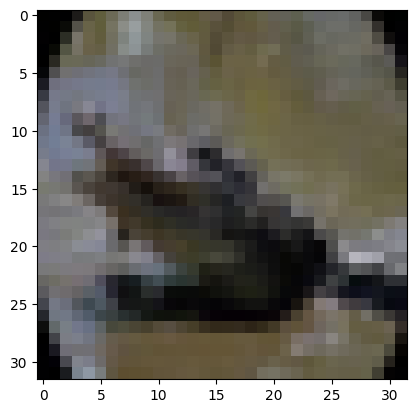

In [ ]:
import matplotlib.pyplot as plt
index_pic = 92
print(list(y_test[index_pic]).index(1))
print(fine_labels[list(y_test[index_pic]).index(1)])
print(x_test[index_pic].shape)
plt.imshow(x_test[index_pic])

In [ ]:
print(0.5/output_scale + output_zero_point)

128.0


In [ ]:


# Specify the path to your .tar file
tar_file_path = 'drive/MyDrive/DL_Project/CFAR100/CIFAR-100-C.tar'

# Open the .tar file
with tarfile.open(tar_file_path, 'r') as tar:
    # Extract all files in the .tar file to the current directory
    tar.extractall()

In [ ]:
img_set1 = np.load('CIFAR-100-C/gaussian_noise.npy')

In [ ]:
img_set1 = img_set1[40000:]

In [ ]:
print(len(np.load('CIFAR-100-C/brightness.npy')))

50000


In [ ]:
img_set1 = img_set1[:100]

In [ ]:
img_set1 = img_set1.astype(np.float32) / 255.0

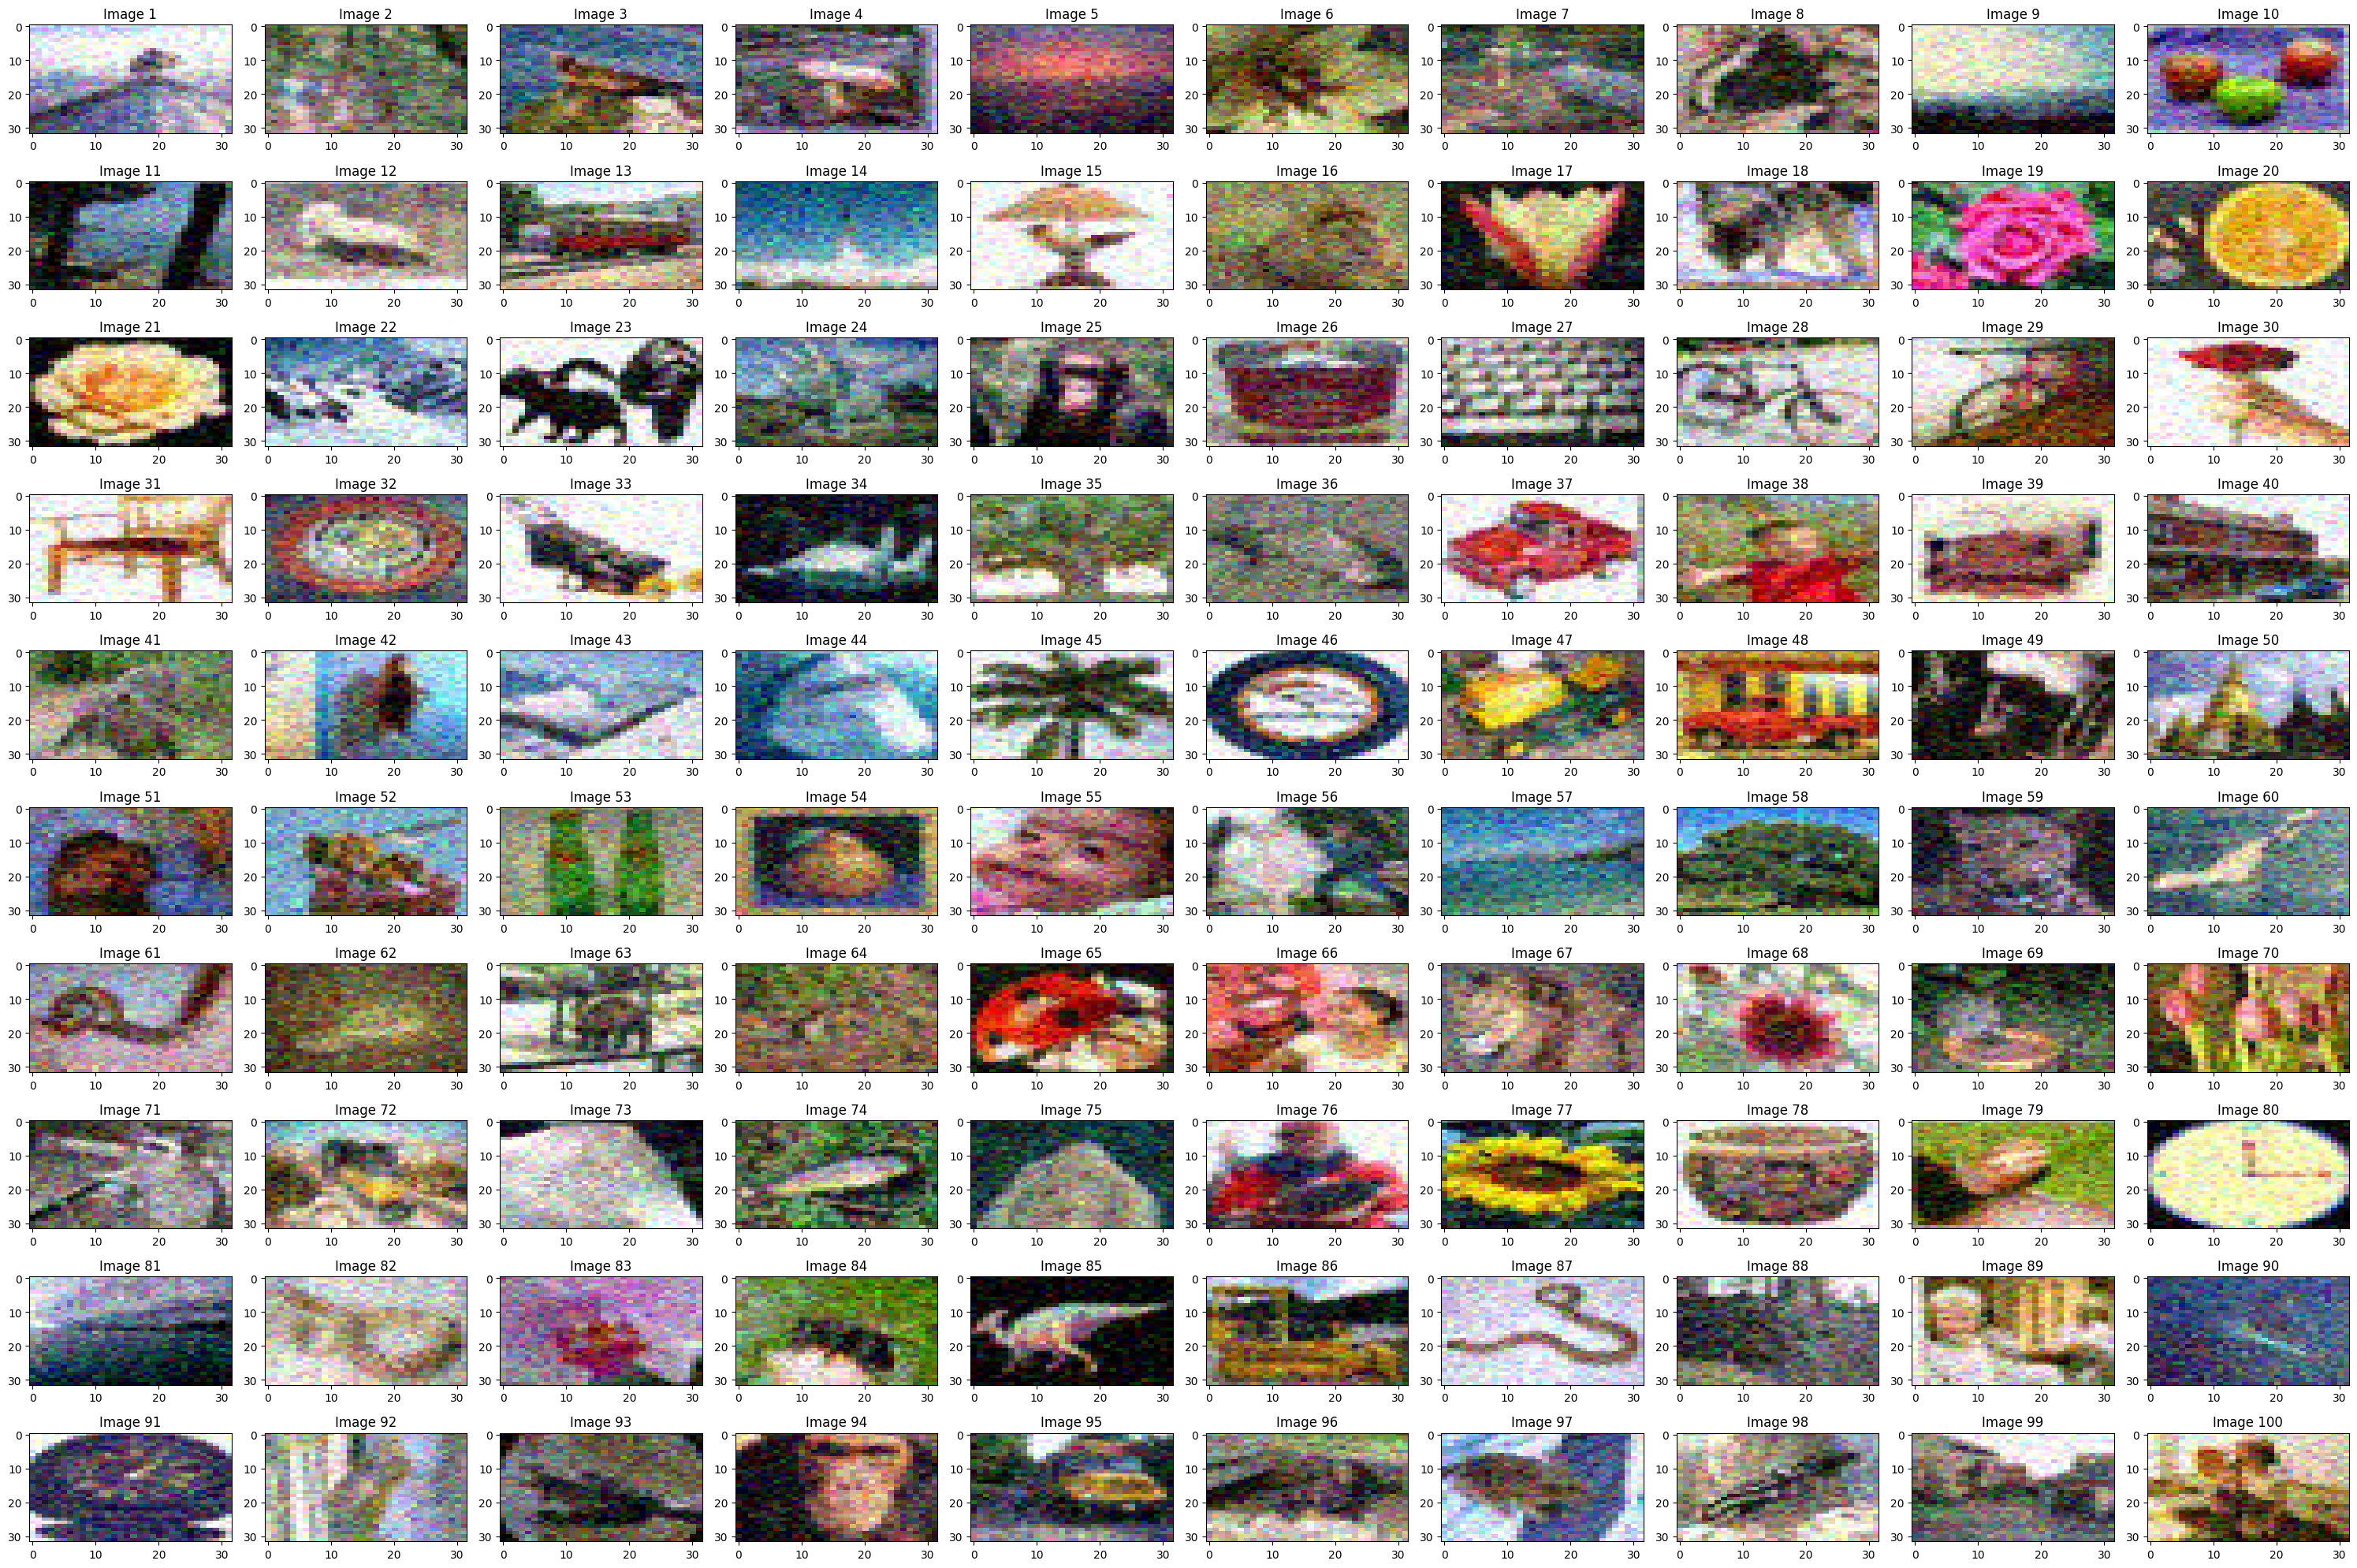

In [ ]:
# Number of images
num_images = len(img_set1)

# Set up the subplot grid dynamically based on the number of images
num_cols = 10
num_rows = -(-num_images // num_cols)  # Equivalent to math.ceil(num_images / num_cols)

# Set the figure size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 20))

# Flatten the axes array to iterate over all subplots
axes = axes.flatten()

# Create subplots
for i in range(num_images):
    axes[i].imshow(img_set1[i], aspect='auto')  # Use cmap if the images are grayscale
    axes[i].set_title(f'Image {i + 1}')

# Hide empty subplots if there are more subplots than images
for j in range(num_images, num_rows * num_cols):
    fig.delaxes(axes[j])

# Adjust layout for better display
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
p_whole = run_mc_eval_on_dataset(tflite_models_dir+model_file_name, 10, num_classes, 0.9, 0.5)

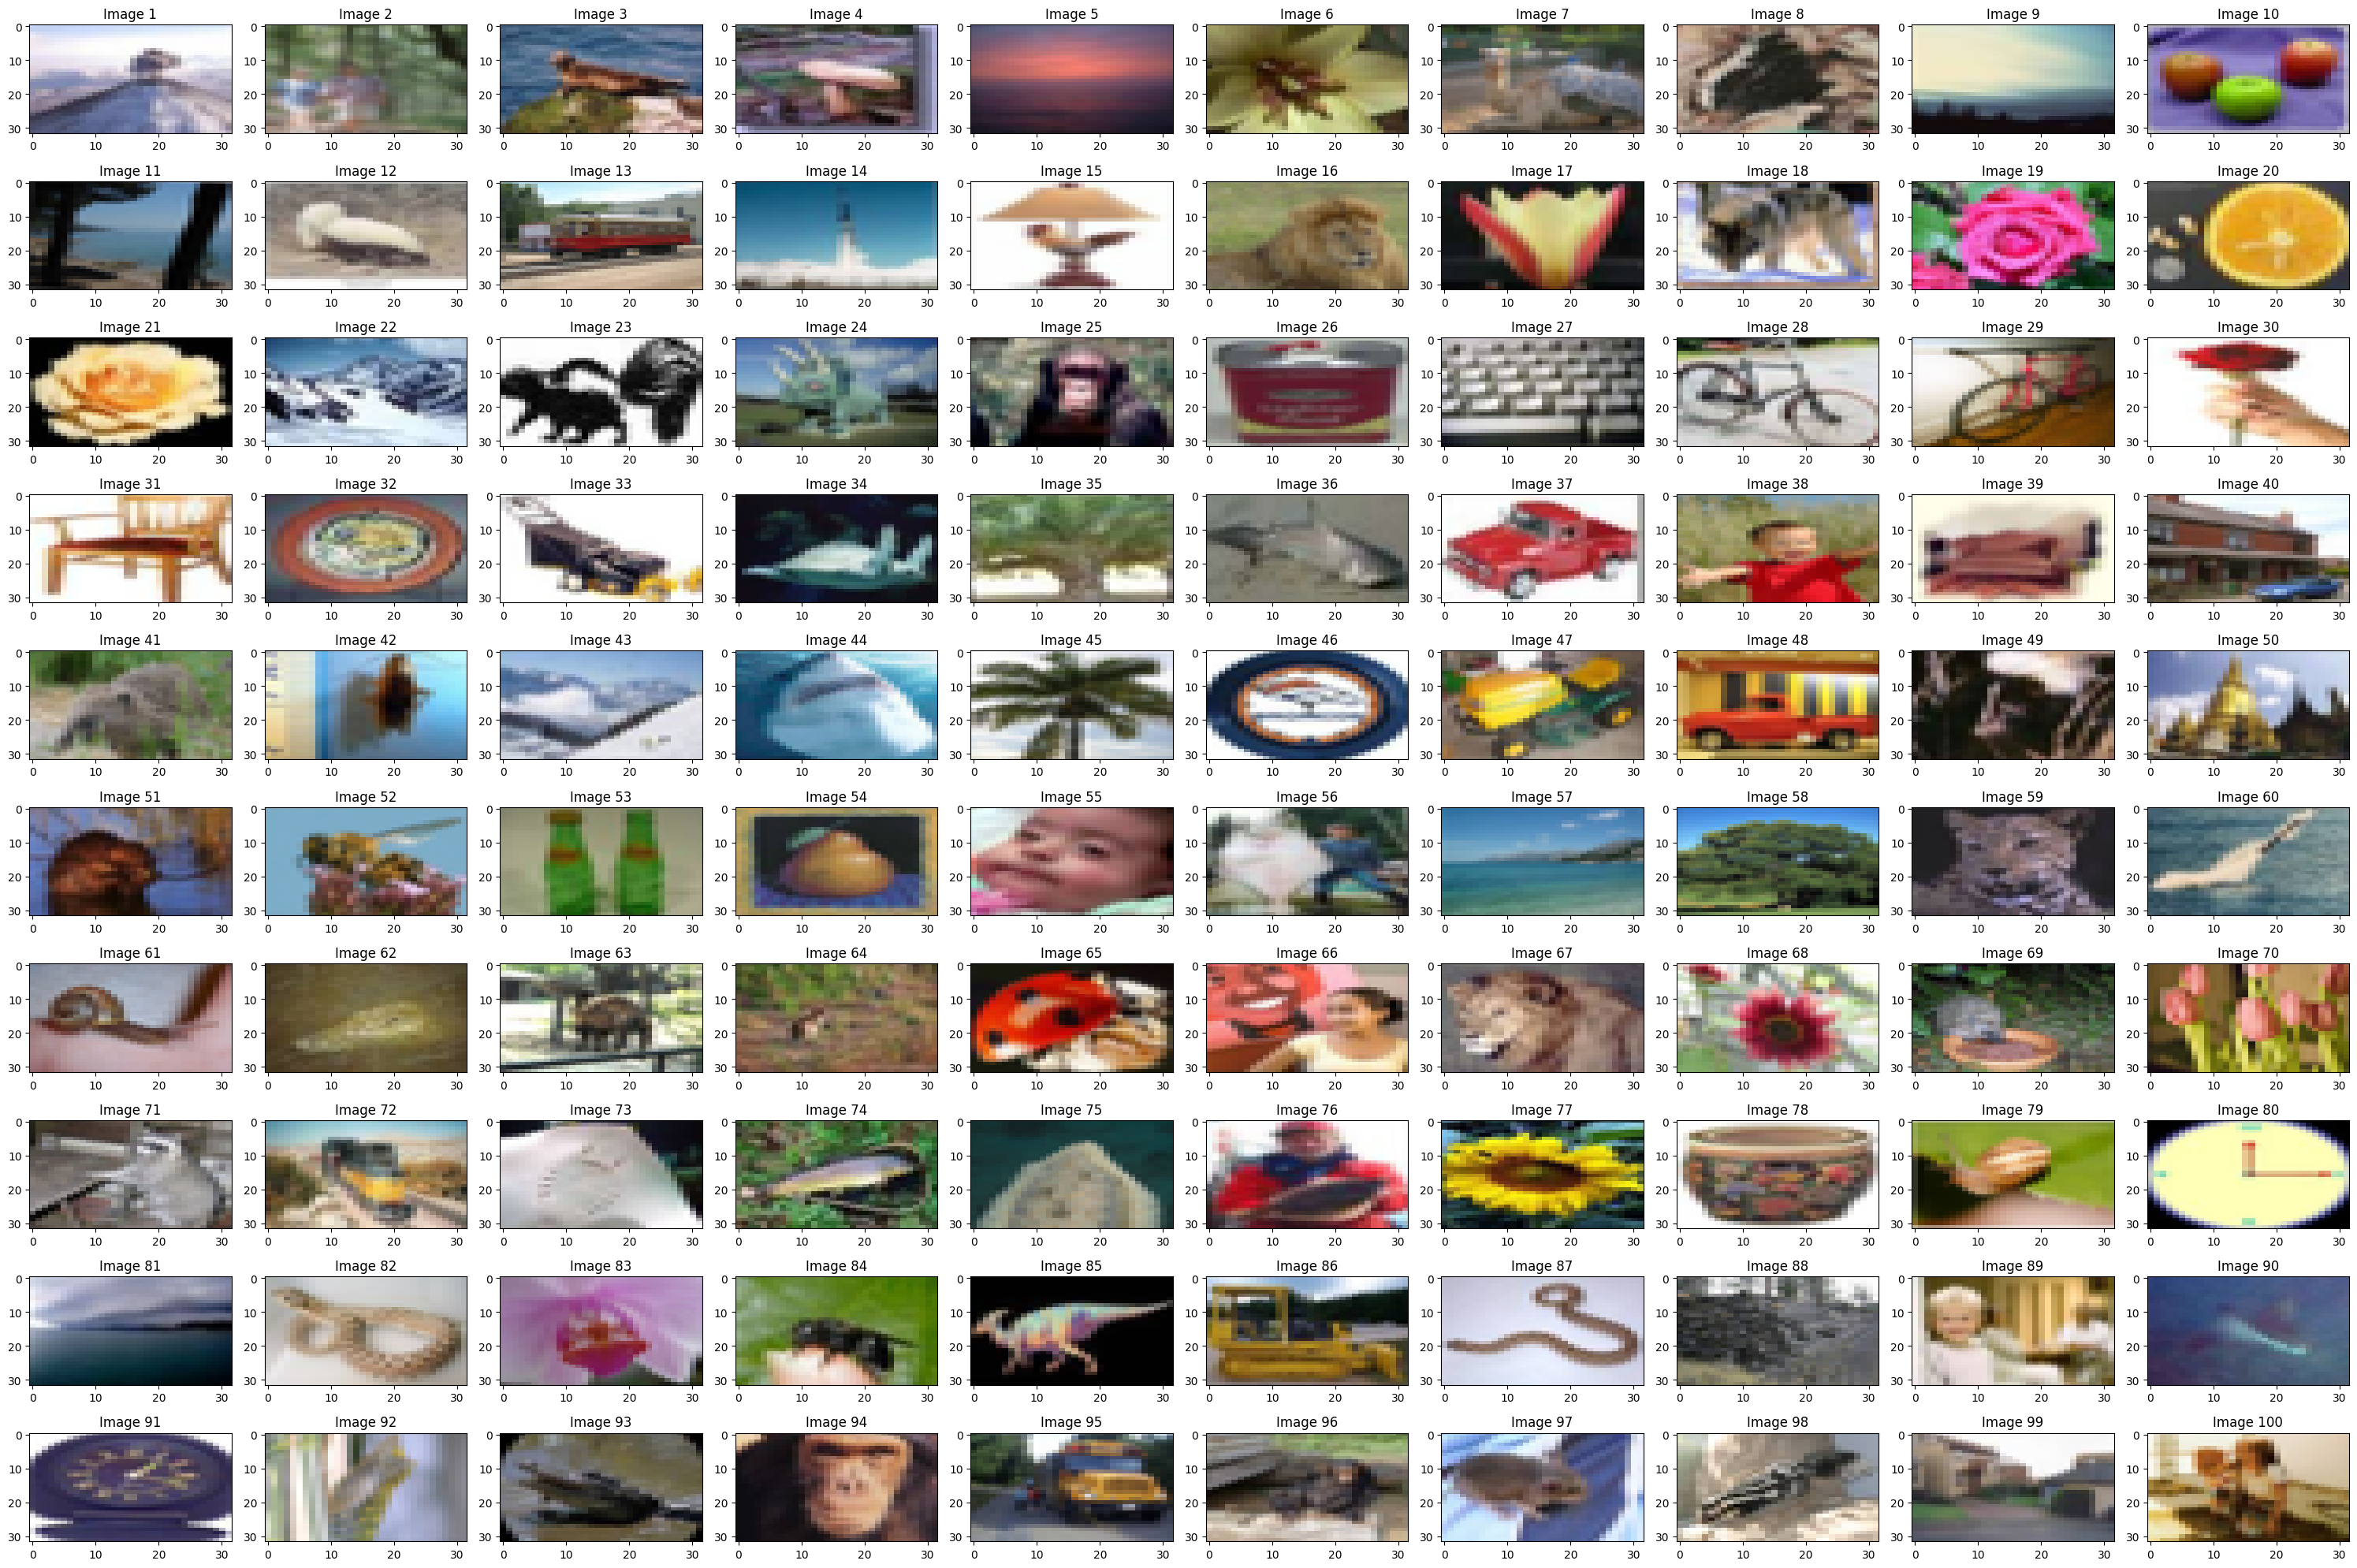

In [ ]:
# Number of images
num_images = 100

# Set up the subplot grid dynamically based on the number of images
num_cols = 10
num_rows = -(-num_images // num_cols)  # Equivalent to math.ceil(num_images / num_cols)

# Set the figure size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 20))

# Flatten the axes array to iterate over all subplots
axes = axes.flatten()

# Create subplots
for i in range(num_images):
    axes[i].imshow(x_test[i], aspect='auto')  # Use cmap if the images are grayscale
    axes[i].set_title(f'Image {i + 1}')

# Hide empty subplots if there are more subplots than images
for j in range(num_images, num_rows * num_cols):
    fig.delaxes(axes[j])

# Adjust layout for better display
plt.tight_layout()

# Show the plot
plt.show()

# **Analysis Part of the Ignored Samples for CFAR100**

In [ ]:
# Helper function to evaluate a TFLite model on specific images
def inference_analysis(x_test, y_test, tflite_file, model_type, test_index):
  print(len(x_test))
  x_tes = x_test[0:100]
  y_tes = y_test[0:100]
  # print(x_tes)
  test_image_indices = [test_index]
  print(len(test_image_indices))
  predictions = run_tflite_model(tflite_file, test_image_indices)
  print(predictions)
  accuracy = accuracy_score(predictions, [y_tes[test_index]])*100
  f1_score_val = f1_score(predictions, [y_tes[test_index]], average='micro')*100

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(x_tes)))
  print('%s model f1 score is %.4f%% (Number of test samples=%d)' % (
      model_type, f1_score_val, len(x_tes)))
  return accuracy, f1_score_val, predictions

In [ ]:
misclassified_samples = 0
ignored_samples = [1,8,12,21,33,37,39,46,50,69,84,88,92,7,23,35,48,49,63,70,71,96,99]
misclassified_samples_indexes = []
for ignored_sample_index in ignored_samples:
    print("For ignored sample: ", str(ignored_sample_index))
    acc, f1,_ = inference_analysis(x_test, y_test, tflite_model_quant_file, "Quantized", ignored_sample_index)
    if(f1==0):
        misclassified_samples += 1
        misclassified_samples_indexes.append(ignored_sample_index)
    print()

print("Misclassified %age = ", str(misclassified_samples/len(ignored_samples)))
print("Misclassified samples indexes = ", misclassified_samples_indexes)


For ignored sample:  1
10000
1
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]]
Quantized model accuracy is 0.0000% (Number of test samples=100)
Quantized model f1 score is 0.0000% (Number of test samples=100)

For ignored sample:  8
10000
1
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]]
Quantized model accuracy is 100.0000% (Number of test samples=100)
Quantized model f1 score is 100.0000% (Number of test samples=100)

For ignored sample:  12
10000
1
[[0. 0. 0. 0. 0.

In [ ]:
fine_labels = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

[1, 33, 37, 46, 84, 88, 7, 23, 48, 49, 63, 70, 71, 96, 99]
15 15


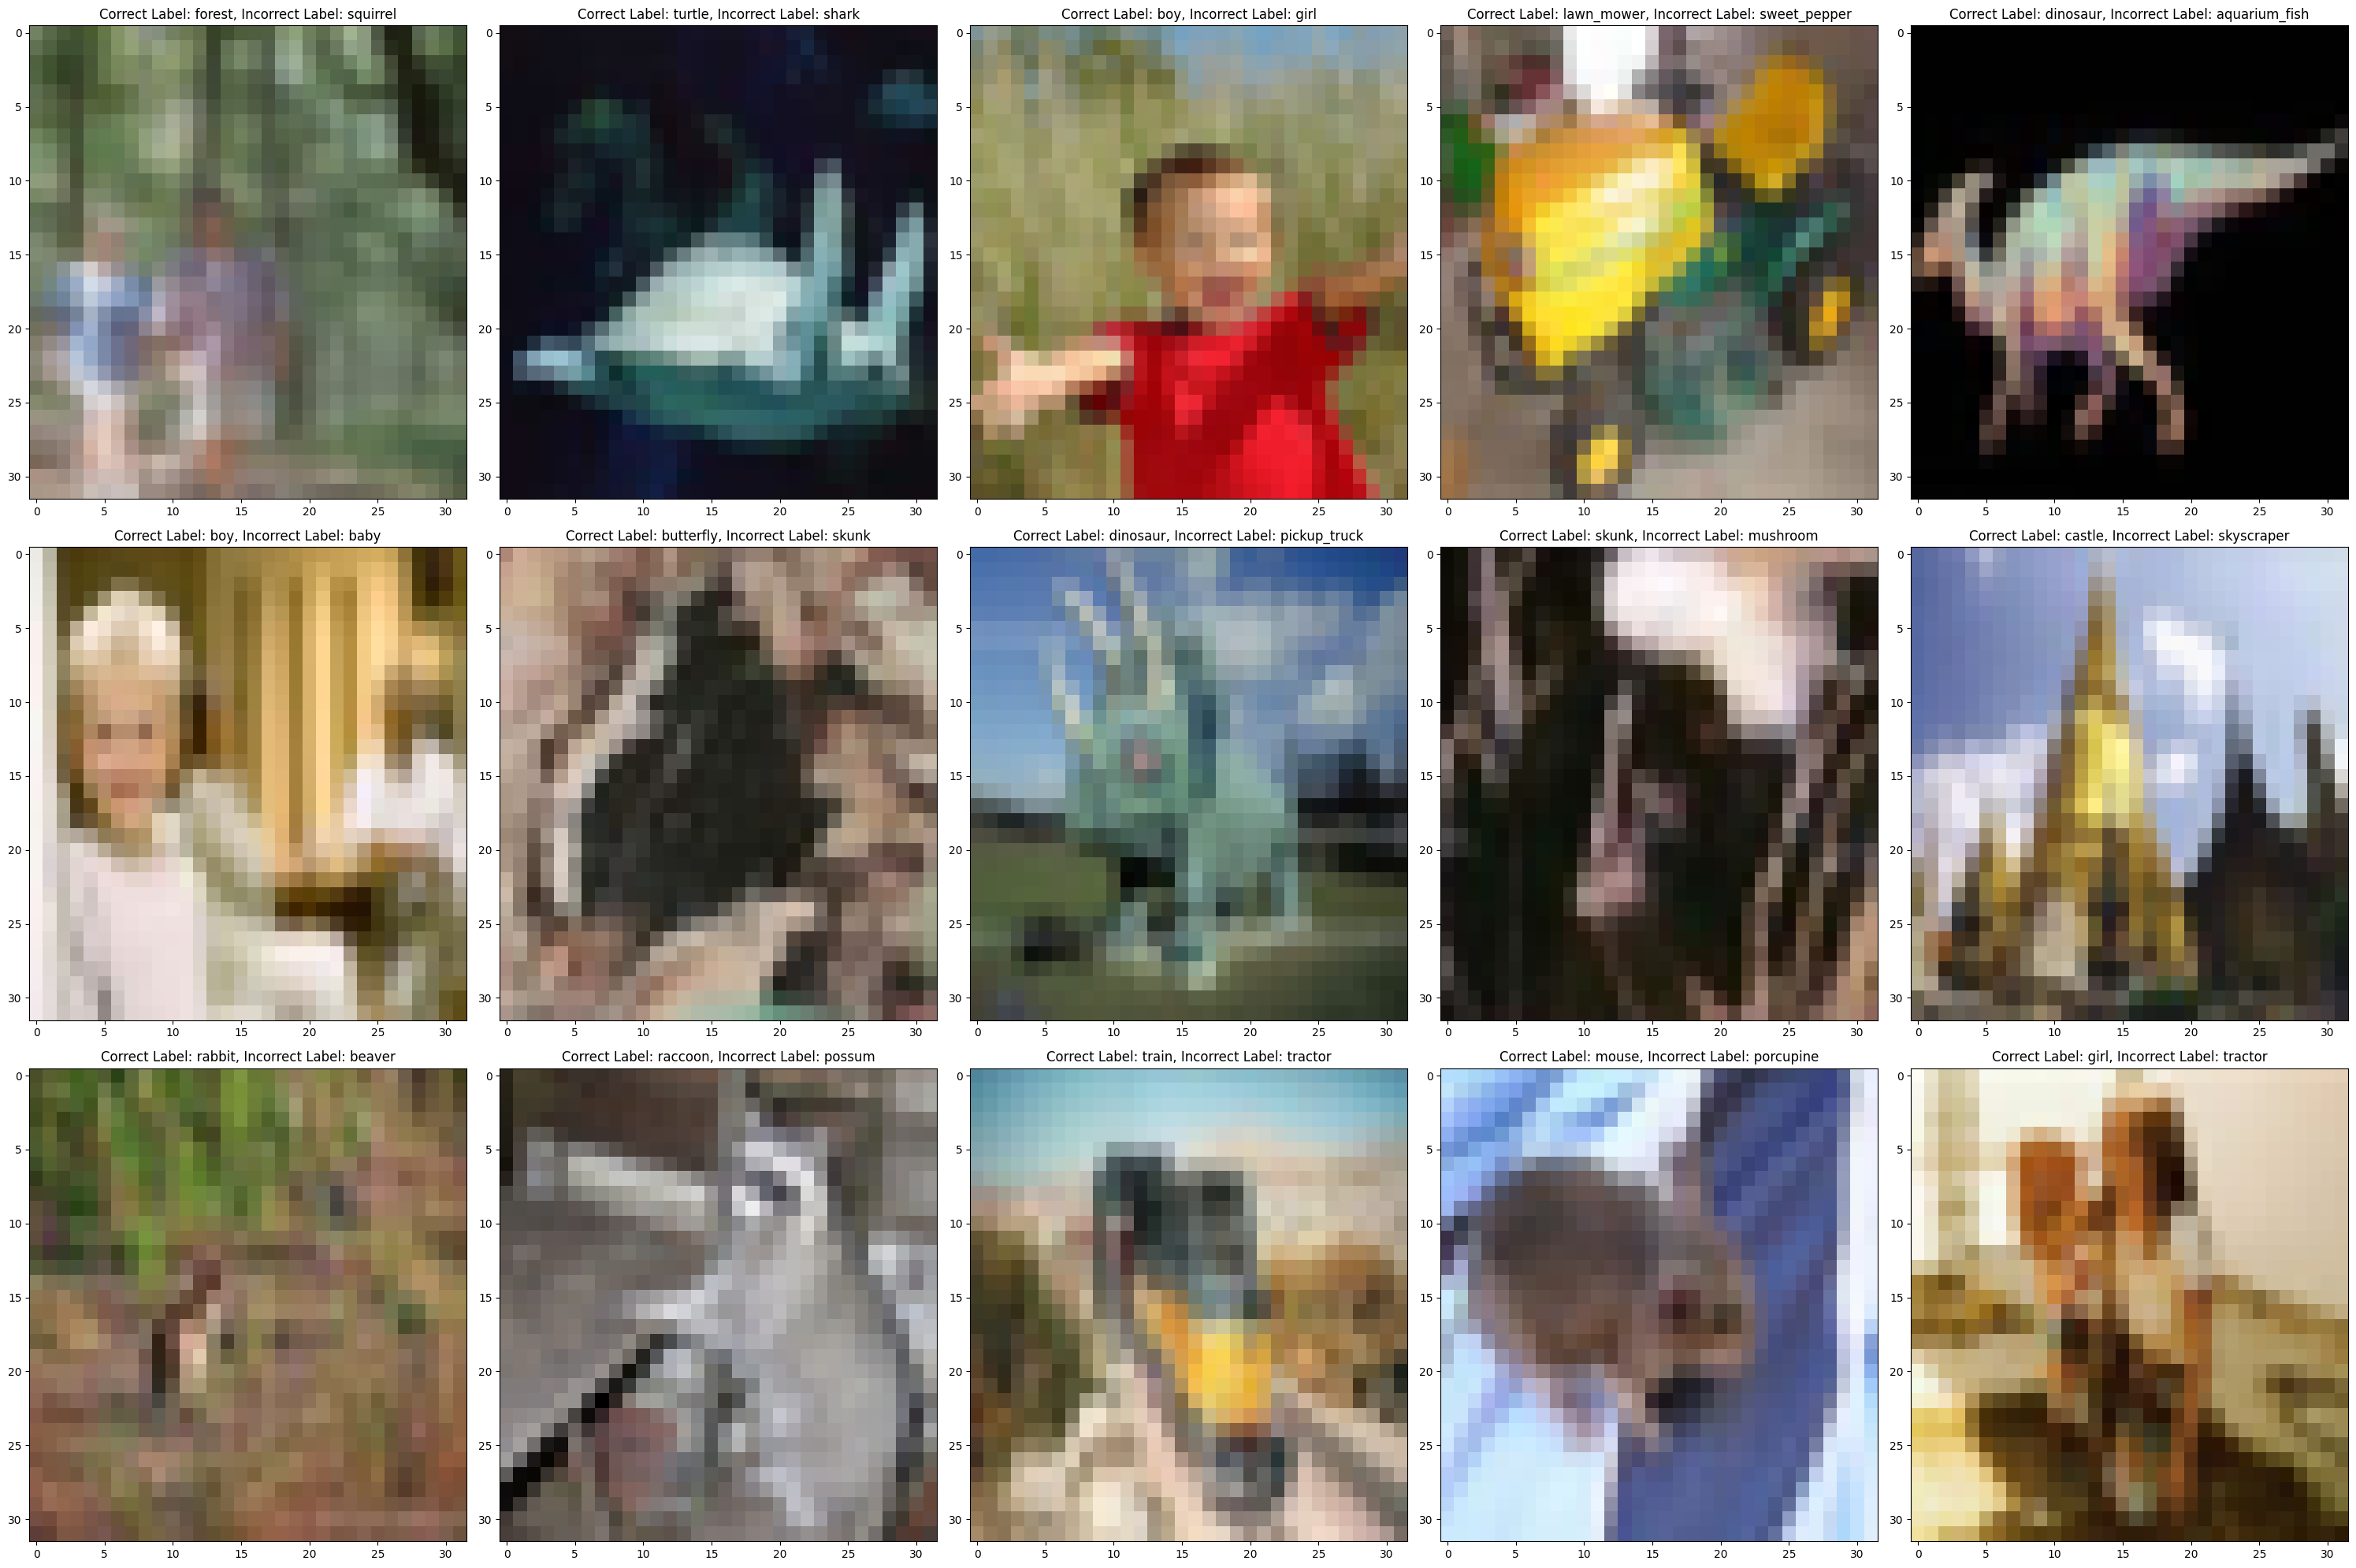

In [ ]:
incorrect_labels = [80,73,35,83,1,2,75,58,51,76,4,64,89,63,89]
print(misclassified_samples_indexes)
# Number of images
num_images = len(misclassified_samples_indexes)
print(len(misclassified_samples_indexes), len(incorrect_labels))

# Set up the subplot grid dynamically based on the number of images
num_cols = 5
num_rows = -(-num_images // num_cols)  # Equivalent to math.ceil(num_images / num_cols)

# Set the figure size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 20))

# Flatten the axes array to iterate over all subplots
axes = axes.flatten()

# Create subplots
for i in range(num_images):
    axes[i].imshow(x_test[misclassified_samples_indexes[i]], aspect='auto')  # Use cmap if the images are grayscale
    axes[i].set_title('Correct Label: ' + str(fine_labels[list(y_test[misclassified_samples_indexes[i]]).index(1)])+ ", Incorrect Label: " + str(fine_labels[incorrect_labels[i]]))

# Hide empty subplots if there are more subplots than images
for j in range(num_images, num_rows * num_cols):
    fig.delaxes(axes[j])

# Adjust layout for better display
plt.tight_layout()

# Show the plot
plt.show()

# **Analysis Part of the Ignored Samples for CFAR100-C(Severity - 1)**


In [ ]:
noise_types = ["defocus_blur.npy", "snow.npy", "elastic_transform.npy", "gaussian_noise.npy"]
ignored_samples_arr = [[1,2,3,6,9,13,17], [0,1,2,4,5,7,8,9,10,15,16], [1,3,6,9,11,12,17,18], [0,3,5,8,9,10,12,13,15,16,17,19]]
misclassified_samples_indexes_cfar100c_sev1 = []
misclassified_samples_labels_cfar100c_sev1 = []

for i in range(len(noise_types)):
    misclassified_samples = 0
    noise = noise_types[i]
    print("For noise: ", noise)
    img_set = np.load('CIFAR-100-C/'+noise)
    img_set = img_set[:20]
    index_arr = []
    incorrect_labels_arr = []
    ignored_samples = ignored_samples_arr[i]

    for ignored_sample_index in ignored_samples:
        print("For ignored sample: ", str(ignored_sample_index))
        acc, f1, pred = inference_analysis(img_set, y_test, tflite_model_quant_file, "Quantized", ignored_sample_index)
        if(f1==0):
            misclassified_samples += 1
            index_1 = list(pred[0]).index(1)
            incorrect_labels_arr.append(index_1)
            index_arr.append(ignored_sample_index)
        print()

    misclassified_samples_labels_cfar100c_sev1.append(incorrect_labels_arr)
    misclassified_samples_indexes_cfar100c_sev1.append(index_arr)

    print("Misclassified %age = ", str(misclassified_samples/len(ignored_samples)))
    print("Misclassified samples indexes = ", index_arr)
    print("Misclassified samples labels = ", incorrect_labels_arr)
    print()



For noise:  defocus_blur.npy
For ignored sample:  1
20
1
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]]
Quantized model accuracy is 0.0000% (Number of test samples=20)
Quantized model f1 score is 0.0000% (Number of test samples=20)

For ignored sample:  2
20
1
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]]
Quantized model accuracy is 0.0000% (Number of test samples=20)
Quantized model f1 score is 0.0000% (Number of test samples=20)

For ignored sample:  3
20
1
[[0. 

In [ ]:
misclassified_samples_indexes_cfar100c_sev1 = [[1, 2, 9, 17], [0, 2, 5, 7, 8], [1, 12, 17], [0, 5, 8, 9]]
misclassified_samples_labels_cfar100c_sev1 = [[80, 30, 53, 88], [68, 30, 6, 75, 71],[80, 90, 88],[68, 6, 71, 53]]

[[80, 30, 53, 88], [68, 30, 6, 75, 71], [80, 90, 88], [68, 6, 71, 53]]
[[1, 2, 9, 17], [0, 2, 5, 7, 8], [1, 12, 17], [0, 5, 8, 9]]
For defocus blur: 


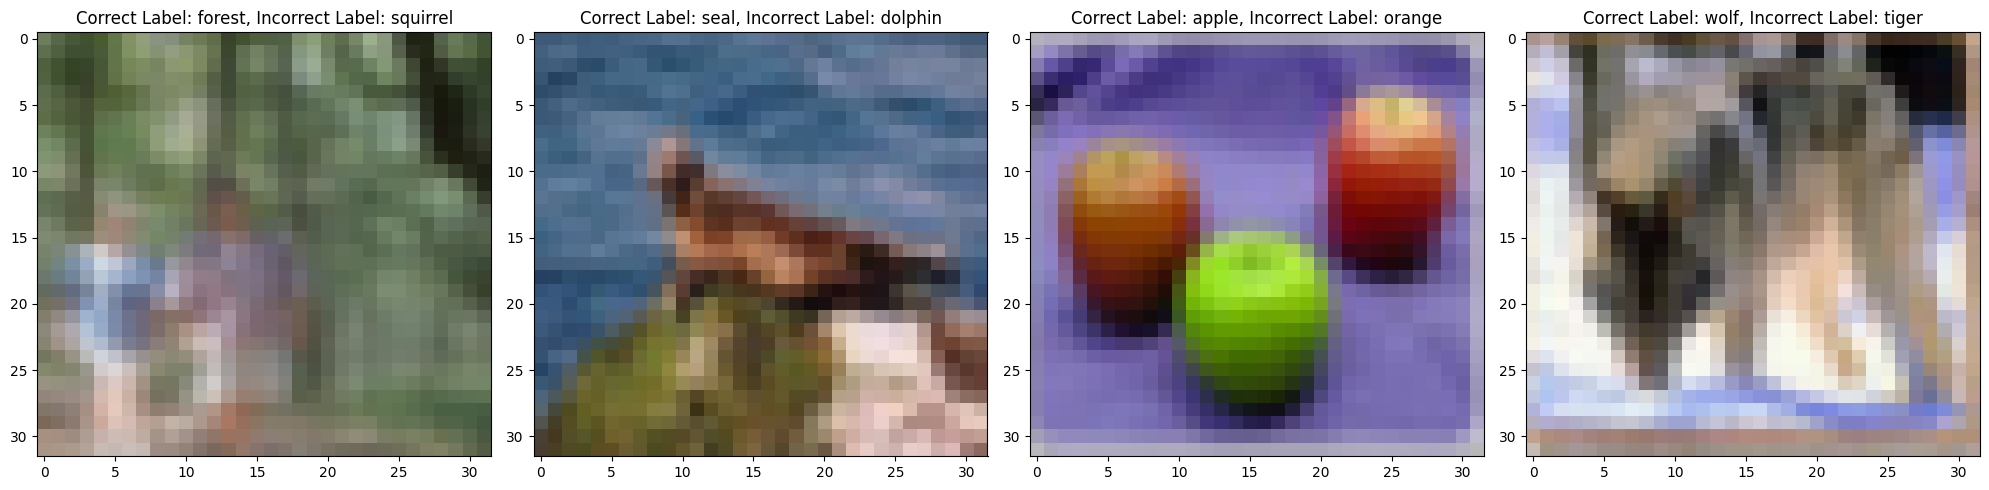

In [ ]:
print(misclassified_samples_labels_cfar100c_sev1)
print(misclassified_samples_indexes_cfar100c_sev1)
print("For defocus blur: ")
# Number of images
num_images = len(misclassified_samples_indexes_cfar100c_sev1[0])

# Set up the subplot grid dynamically based on the number of images
num_cols = 4
num_rows = -(-num_images // num_cols)  # Equivalent to math.ceil(num_images / num_cols)

# Set the figure size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5))

# Flatten the axes array to iterate over all subplots
axes = axes.flatten()

# Create subplots
img_set_defocus_blur = np.load("CIFAR-100-C/defocus_blur.npy")
for i in range(num_images):
    axes[i].imshow(img_set_defocus_blur[misclassified_samples_indexes_cfar100c_sev1[0][i]], aspect='auto')  # Use cmap if the images are grayscale
    axes[i].set_title('Correct Label: ' + str(fine_labels[list(y_test[misclassified_samples_indexes_cfar100c_sev1[0][i]]).index(1)])+ ", Incorrect Label: " + str(fine_labels[misclassified_samples_labels_cfar100c_sev1[0][i]]))

# Hide empty subplots if there are more subplots than images
for j in range(num_images, num_rows * num_cols):
    fig.delaxes(axes[j])

# Adjust layout for better display
plt.tight_layout()

# Show the plot
plt.show()

[[80, 30, 53, 88], [68, 30, 6, 75, 71], [80, 90, 88], [68, 6, 71, 53]]
[[1, 2, 9, 17], [0, 2, 5, 7, 8], [1, 12, 17], [0, 5, 8, 9]]
For snow: 


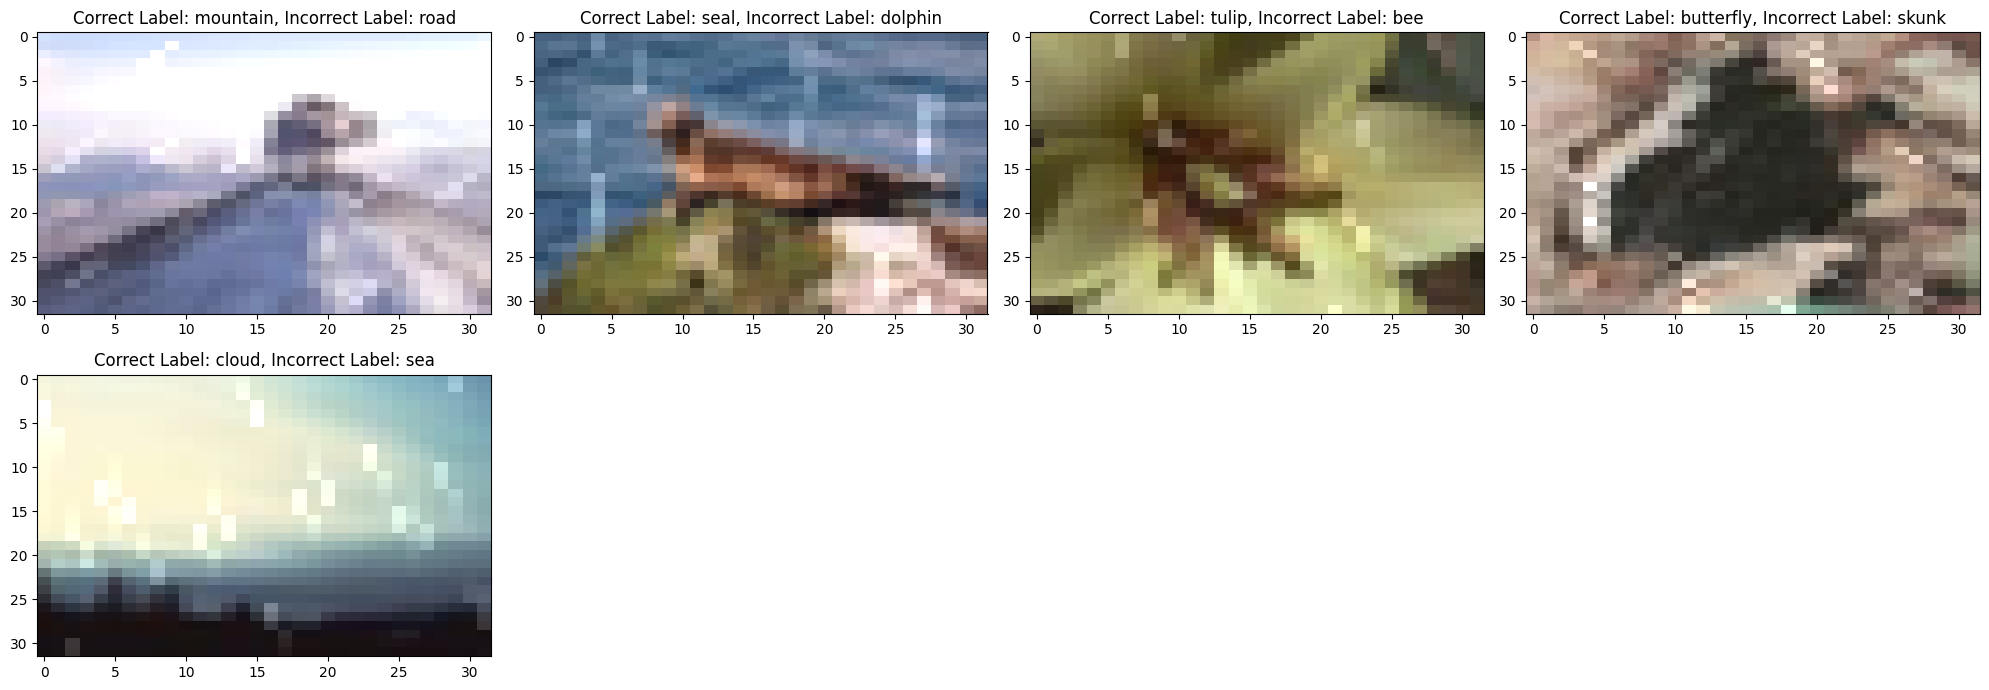

In [ ]:
print(misclassified_samples_labels_cfar100c_sev1)
print(misclassified_samples_indexes_cfar100c_sev1)
print("For snow: ")
# Number of images
num_images = len(misclassified_samples_indexes_cfar100c_sev1[1])

# Set up the subplot grid dynamically based on the number of images
num_cols = 4
num_rows = -(-num_images // num_cols)  # Equivalent to math.ceil(num_images / num_cols)

# Set the figure size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 7))

# Flatten the axes array to iterate over all subplots
axes = axes.flatten()

# Create subplots
img_set_defocus_blur = np.load("CIFAR-100-C/snow.npy")
for i in range(num_images):
    axes[i].imshow(img_set_defocus_blur[misclassified_samples_indexes_cfar100c_sev1[1][i]], aspect='auto')  # Use cmap if the images are grayscale
    axes[i].set_title('Correct Label: ' + str(fine_labels[list(y_test[misclassified_samples_indexes_cfar100c_sev1[1][i]]).index(1)])+ ", Incorrect Label: " + str(fine_labels[misclassified_samples_labels_cfar100c_sev1[1][i]]))

# Hide empty subplots if there are more subplots than images
for j in range(num_images, num_rows * num_cols):
    fig.delaxes(axes[j])

# Adjust layout for better display
plt.tight_layout()

# Show the plot
plt.show()

[[80, 30, 53, 88], [68, 30, 6, 75, 71], [80, 90, 88], [68, 6, 71, 53]]
[[1, 2, 9, 17], [0, 2, 5, 7, 8], [1, 12, 17], [0, 5, 8, 9]]
For elastic transform: 


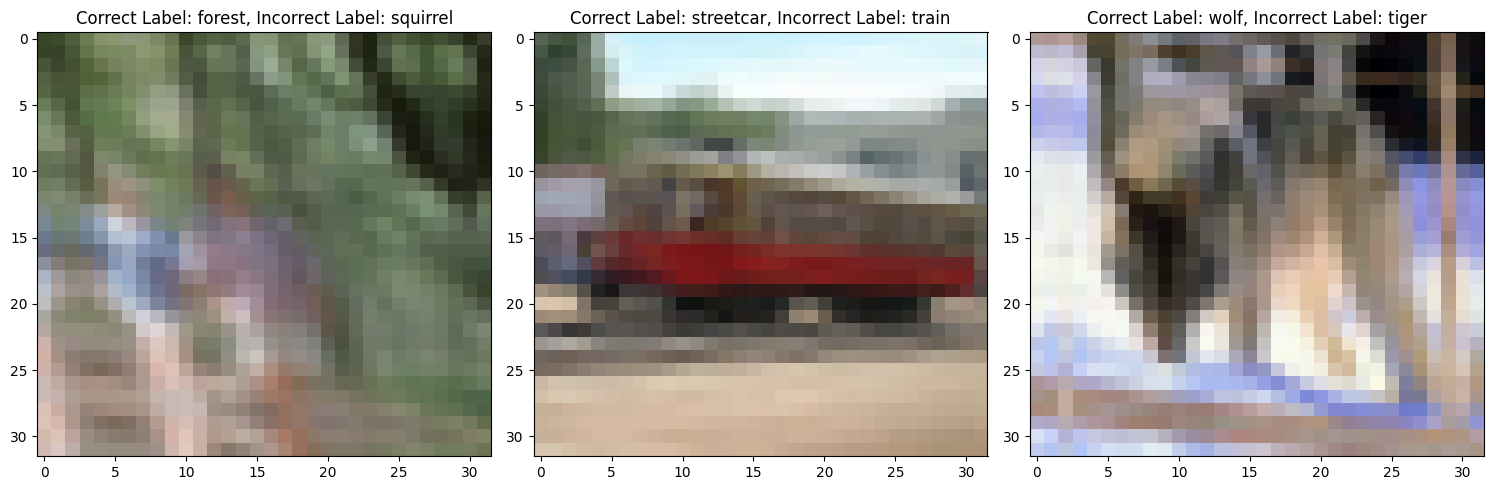

In [ ]:
print(misclassified_samples_labels_cfar100c_sev1)
print(misclassified_samples_indexes_cfar100c_sev1)
print("For elastic transform: ")
# Number of images
num_images = len(misclassified_samples_indexes_cfar100c_sev1[2])

# Set up the subplot grid dynamically based on the number of images
num_cols = 4
num_rows = -(-num_images // num_cols)  # Equivalent to math.ceil(num_images / num_cols)

# Set the figure size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5))

# Flatten the axes array to iterate over all subplots
axes = axes.flatten()

# Create subplots
img_set_defocus_blur = np.load("CIFAR-100-C/elastic_transform.npy")
for i in range(num_images):
    axes[i].imshow(img_set_defocus_blur[misclassified_samples_indexes_cfar100c_sev1[2][i]], aspect='auto')  # Use cmap if the images are grayscale
    axes[i].set_title('Correct Label: ' + str(fine_labels[list(y_test[misclassified_samples_indexes_cfar100c_sev1[2][i]]).index(1)])+ ", Incorrect Label: " + str(fine_labels[misclassified_samples_labels_cfar100c_sev1[2][i]]))

# Hide empty subplots if there are more subplots than images
for j in range(num_images, num_rows * num_cols):
    fig.delaxes(axes[j])

# Adjust layout for better display
plt.tight_layout()

# Show the plot
plt.show()

[[80, 30, 53, 88], [68, 30, 6, 75, 71], [80, 90, 88], [68, 6, 71, 53]]
[[1, 2, 9, 17], [0, 2, 5, 7, 8], [1, 12, 17], [0, 5, 8, 9]]
For gaussian noise: 


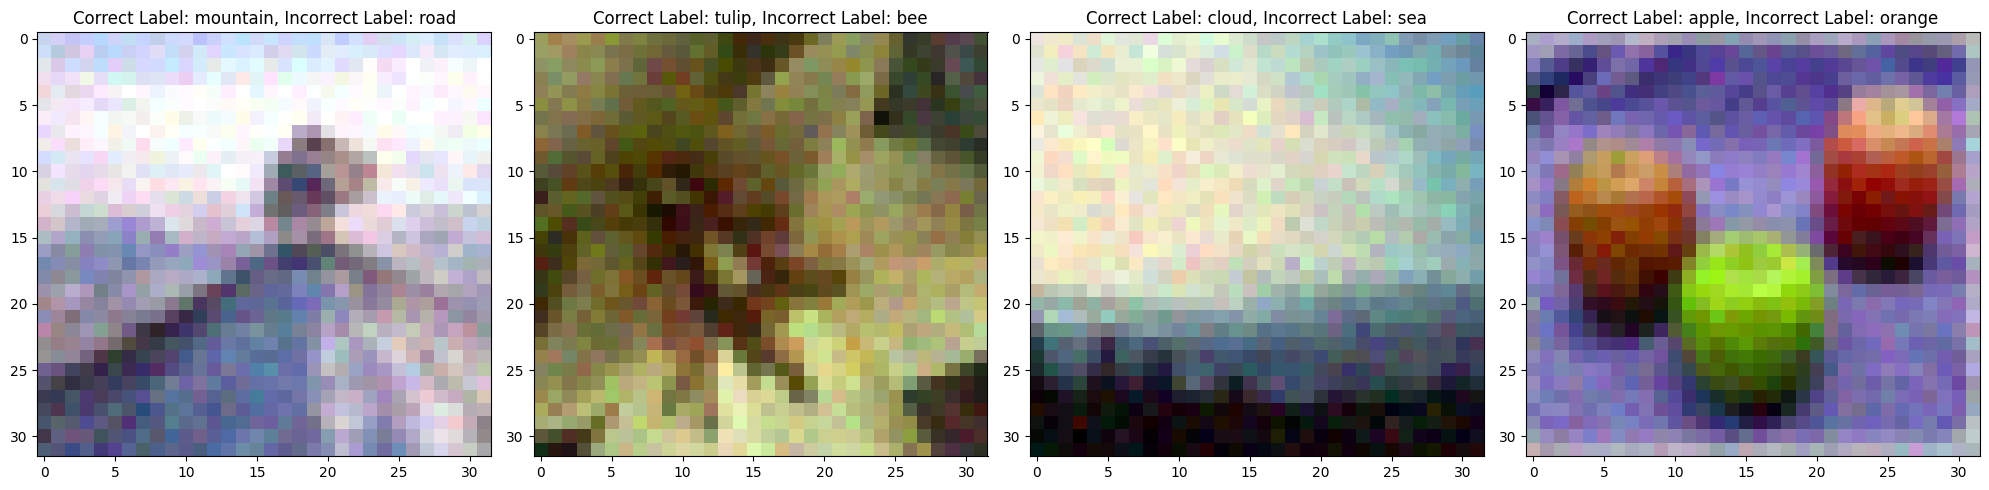

In [ ]:
print(misclassified_samples_labels_cfar100c_sev1)
print(misclassified_samples_indexes_cfar100c_sev1)
print("For gaussian noise: ")
# Number of images
num_images = len(misclassified_samples_indexes_cfar100c_sev1[3])

# Set up the subplot grid dynamically based on the number of images
num_cols = 4
num_rows = -(-num_images // num_cols)  # Equivalent to math.ceil(num_images / num_cols)

# Set the figure size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5))

# Flatten the axes array to iterate over all subplots
axes = axes.flatten()

# Create subplots
img_set_defocus_blur = np.load("CIFAR-100-C/gaussian_noise.npy")
for i in range(num_images):
    axes[i].imshow(img_set_defocus_blur[misclassified_samples_indexes_cfar100c_sev1[3][i]], aspect='auto')  # Use cmap if the images are grayscale
    axes[i].set_title('Correct Label: ' + str(fine_labels[list(y_test[misclassified_samples_indexes_cfar100c_sev1[3][i]]).index(1)])+ ", Incorrect Label: " + str(fine_labels[misclassified_samples_labels_cfar100c_sev1[3][i]]))

# Hide empty subplots if there are more subplots than images
for j in range(num_images, num_rows * num_cols):
    fig.delaxes(axes[j])

# Adjust layout for better display
plt.tight_layout()

# Show the plot
plt.show()

# **Analysis Part of the Ignored Samples for CFAR100-C(Severity - 5)**


In [ ]:
noise_types = ["defocus_blur.npy", "snow.npy", "elastic_transform.npy", "gaussian_noise.npy"]
ignored_samples_arr = [[0,1,2,3,6,9,10,11,12,17,19], [0,1,3,4,5,7,10,11,12,13,15,16,17], [0,1,3,10,14,15,16,17,19], [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]]
misclassified_samples_indexes_cfar100c_sev5 = []
misclassified_samples_labels_cfar100c_sev5 = []

for i in range(len(noise_types)):
    misclassified_samples = 0
    noise = noise_types[i]
    print("For noise: ", noise)
    img_set = np.load('CIFAR-100-C/'+noise)
    img_set = img_set[40000:]
    img_set = img_set[:20]
    index_arr = []
    incorrect_labels_arr = []
    ignored_samples = ignored_samples_arr[i]

    for ignored_sample_index in ignored_samples:
        print("For ignored sample: ", str(ignored_sample_index))
        acc, f1, pred = inference_analysis(img_set, y_test, tflite_model_quant_file, "Quantized", ignored_sample_index)
        if(f1==0):
            misclassified_samples += 1
            index_1 = list(pred[0]).index(1)
            incorrect_labels_arr.append(index_1)
            index_arr.append(ignored_sample_index)
        print()

    misclassified_samples_labels_cfar100c_sev5.append(incorrect_labels_arr)
    misclassified_samples_indexes_cfar100c_sev5.append(index_arr)

    print("Misclassified %age = ", str(misclassified_samples/len(ignored_samples)))
    print("Misclassified samples indexes = ", index_arr)
    print("Misclassified samples labels = ", incorrect_labels_arr)
    print()


For noise:  defocus_blur.npy
For ignored sample:  0
20
1
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]]
Quantized model accuracy is 0.0000% (Number of test samples=20)
Quantized model f1 score is 0.0000% (Number of test samples=20)

For ignored sample:  1
20
1
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]]
Quantized model accuracy is 100.0000% (Number of test samples=20)
Quantized model f1 score is 100.0000% (Number of test samples=20)

For ignored sample:  2
20
1
[

Gaussian noise sev 5 - Misclassified %age =  0.42105263157894735
Misclassified samples indexes =  [0, 5, 7, 8, 9, 10, 12, 17]
Misclassified samples labels =  [68, 6, 74, 71, 53, 31, 90, 36]


Defocus blur sev 5 - Misclassified %age =  0.45454545454545453
Misclassified samples indexes =  [0, 1, 2, 9, 12]
Misclassified samples labels =  [68, 80, 30, 53, 90]

Snow sev 5 - Misclassified %age =  0.38461538461538464
Misclassified samples indexes =  [0, 1, 5, 7, 12]
Misclassified samples labels =  [68, 80, 6, 75, 90]

Elastic Transform sev 5- Misclassified %age =  0.3333333333333333
Misclassified samples indexes =  [0, 1, 10]
Misclassified samples labels =  [68, 80, 56]

In [ ]:
misclassified_samples_labels_cfar100c_sev5 = [[68,80,30,53,90],[68, 80, 6, 75, 90], [68, 80, 56], [68, 6, 74, 71, 53, 31, 90, 36]]
misclassified_samples_indexes_cfar100c_sev5 = [[0, 1, 2, 9, 12], [0, 1, 5, 7, 12],[0, 1, 10], [0, 5, 7, 8, 9, 10, 12, 17]]

For defocus blur: 


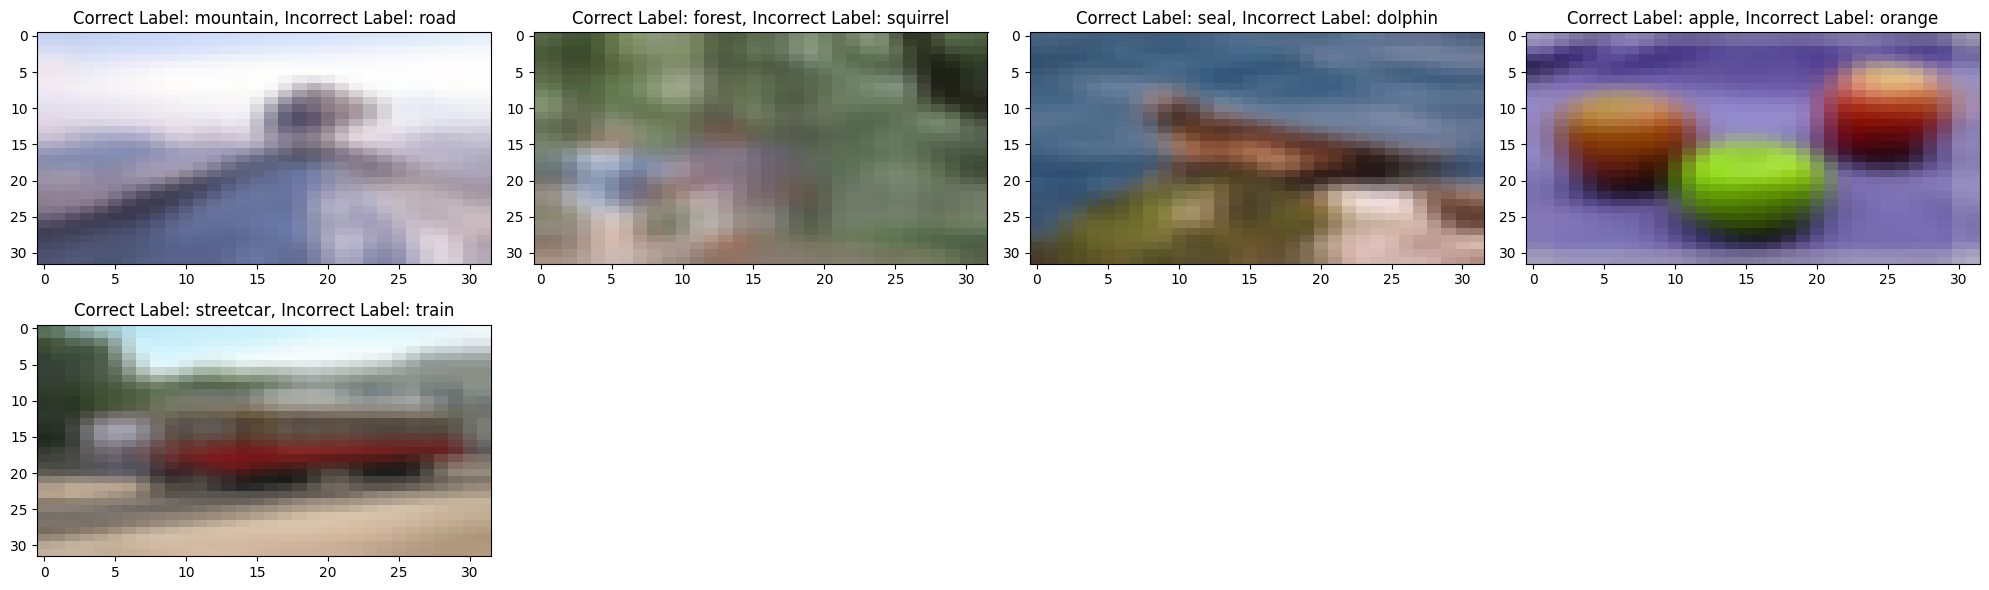

In [ ]:
print("For defocus blur: ")
# Number of images
num_images = len(misclassified_samples_indexes_cfar100c_sev5[0])

# Set up the subplot grid dynamically based on the number of images
num_cols = 4
num_rows = -(-num_images // num_cols)  # Equivalent to math.ceil(num_images / num_cols)

# Set the figure size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 6))

# Flatten the axes array to iterate over all subplots
axes = axes.flatten()

# Create subplots
img_set_defocus_blur = np.load("CIFAR-100-C/defocus_blur.npy")
img_set_defocus_blur = img_set_defocus_blur[40000:]
for i in range(num_images):
    axes[i].imshow(img_set_defocus_blur[misclassified_samples_indexes_cfar100c_sev5[0][i]], aspect='auto')  # Use cmap if the images are grayscale
    axes[i].set_title('Correct Label: ' + str(fine_labels[list(y_test[misclassified_samples_indexes_cfar100c_sev5[0][i]]).index(1)])+ ", Incorrect Label: " + str(fine_labels[misclassified_samples_labels_cfar100c_sev5[0][i]]))

# Hide empty subplots if there are more subplots than images
for j in range(num_images, num_rows * num_cols):
    fig.delaxes(axes[j])

# Adjust layout for better display
plt.tight_layout()

# Show the plot
plt.show()

For snow: 


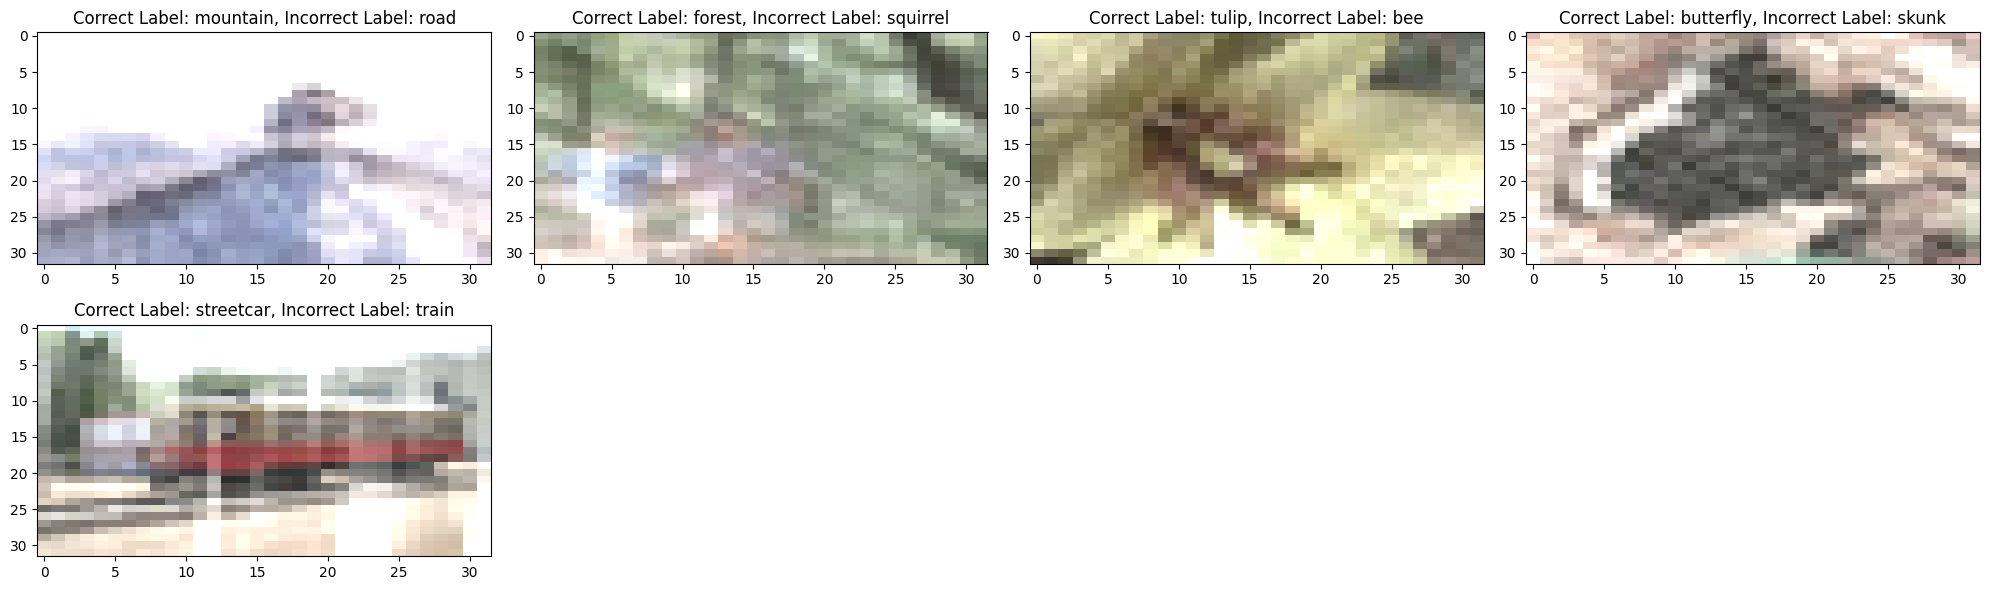

In [ ]:
print("For snow: ")
# Number of images
num_images = len(misclassified_samples_indexes_cfar100c_sev5[1])

# Set up the subplot grid dynamically based on the number of images
num_cols = 4
num_rows = -(-num_images // num_cols)  # Equivalent to math.ceil(num_images / num_cols)

# Set the figure size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 6))

# Flatten the axes array to iterate over all subplots
axes = axes.flatten()

# Create subplots
img_set_defocus_blur = np.load("CIFAR-100-C/snow.npy")
img_set_defocus_blur = img_set_defocus_blur[40000:]
for i in range(num_images):
    axes[i].imshow(img_set_defocus_blur[misclassified_samples_indexes_cfar100c_sev5[1][i]], aspect='auto')  # Use cmap if the images are grayscale
    axes[i].set_title('Correct Label: ' + str(fine_labels[list(y_test[misclassified_samples_indexes_cfar100c_sev5[1][i]]).index(1)])+ ", Incorrect Label: " + str(fine_labels[misclassified_samples_labels_cfar100c_sev5[1][i]]))

# Hide empty subplots if there are more subplots than images
for j in range(num_images, num_rows * num_cols):
    fig.delaxes(axes[j])

# Adjust layout for better display
plt.tight_layout()

# Show the plot
plt.show()

For elastic transform: 
3
4


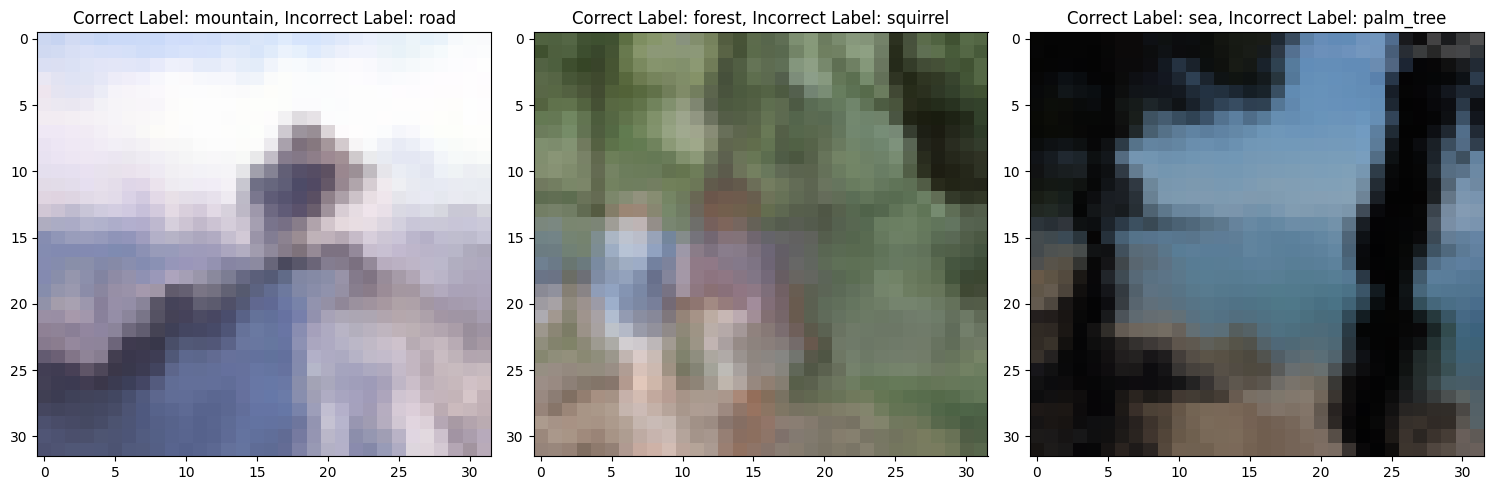

In [ ]:
print("For elastic transform: ")
# Number of images
num_images = len(misclassified_samples_indexes_cfar100c_sev5[2])
print(num_images)

# Set up the subplot grid dynamically based on the number of images
num_cols = 4
num_rows = -(-num_images // num_cols)  # Equivalent to math.ceil(num_images / num_cols)

# Set the figure size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5))

# Flatten the axes array to iterate over all subplots
axes = axes.flatten()
print(len(axes))
# Create subplots
img_set_defocus_blur = np.load("CIFAR-100-C/elastic_transform.npy")
img_set_defocus_blur = img_set_defocus_blur[40000:]
for i in range(num_images):
    axes[i].imshow(img_set_defocus_blur[misclassified_samples_indexes_cfar100c_sev5[2][i]], aspect='auto')  # Use cmap if the images are grayscale
    axes[i].set_title('Correct Label: ' + str(fine_labels[list(y_test[misclassified_samples_indexes_cfar100c_sev5[2][i]]).index(1)])+ ", Incorrect Label: " + str(fine_labels[misclassified_samples_labels_cfar100c_sev5[2][i]]))

# Hide empty subplots if there are more subplots than images
for j in range(num_images, num_rows * num_cols):
    fig.delaxes(axes[j])

# Adjust layout for better display
plt.tight_layout()

# Show the plot
plt.show()

For gaussian noise: 


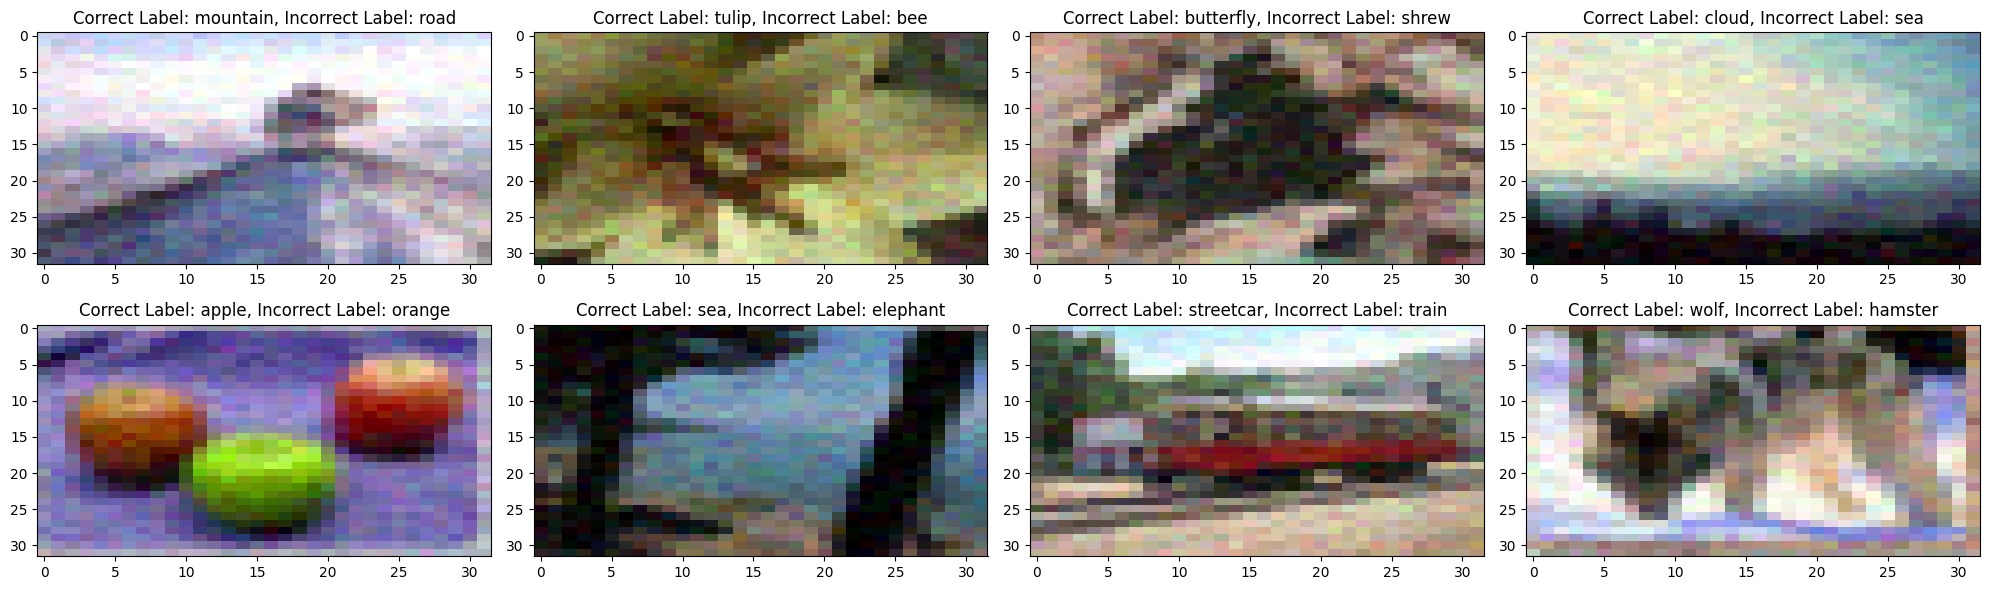

In [ ]:
print("For gaussian noise: ")
# Number of images
num_images = len(misclassified_samples_indexes_cfar100c_sev5[3])

# Set up the subplot grid dynamically based on the number of images
num_cols = 4
num_rows = -(-num_images // num_cols)  # Equivalent to math.ceil(num_images / num_cols)

# Set the figure size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 6))

# Flatten the axes array to iterate over all subplots
axes = axes.flatten()

# Create subplots
img_set_defocus_blur = np.load("CIFAR-100-C/gaussian_noise.npy")
img_set_defocus_blur = img_set_defocus_blur[40000:]
for i in range(num_images):
    axes[i].imshow(img_set_defocus_blur[misclassified_samples_indexes_cfar100c_sev5[3][i]], aspect='auto')  # Use cmap if the images are grayscale
    axes[i].set_title('Correct Label: ' + str(fine_labels[list(y_test[misclassified_samples_indexes_cfar100c_sev5[3][i]]).index(1)])+ ", Incorrect Label: " + str(fine_labels[misclassified_samples_labels_cfar100c_sev5[3][i]]))

# Hide empty subplots if there are more subplots than images
for j in range(num_images, num_rows * num_cols):
    fig.delaxes(axes[j])

# Adjust layout for better display
plt.tight_layout()

# Show the plot
plt.show()